In [12]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [13]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
K = 3
MCMC_SIZE = 10
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 300
NUM_HIDDEN = 32
NUM_NSS = 8
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = 0

RECON_SIGMA = torch.ones(1) * 0.1
RADI = torch.ones(1) * 2.0
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)

if CUDA:
    with torch.cuda.device(DEVICE):
        lg2pi = lg2pi.cuda().to(DEVICE)
PATH = 'ag--phase3-2'

In [14]:
from local_oneshot_state import *
from local_enc_angle import *
from decoder import *
# initialization
oneshot_state = Oneshot_state(K, D, NUM_HIDDEN, CUDA, DEVICE)
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
dec_x = Dec_x(D, NUM_HIDDEN, RECON_SIGMA, CUDA, DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        oneshot_state.cuda()
        enc_angle.cuda()
        dec_x.cuda()
        lg2pi = lg2pi.cuda().to(DEVICE)

optimizer =  torch.optim.Adam(list(dec_x.parameters())+list(oneshot_state.parameters())+list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

models = (oneshot_state, enc_angle, dec_x)

In [15]:
from ag_ep_pcg_v2 import *
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    ELBO = 0.0
    EUBO = 0.0
    ESS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        mu = MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        ob = shuffler(ob).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob = ob.cuda()
                mu = mu.cuda()
        q_state, p_state = oneshot_state.forward(ob, mu, K)
        state = q_state['zs'].value ## S * B * N * K
        q_angle, p_angle = enc_angle(ob, state, mu)
        angle = q_angle['angles'].value * 2 * math.pi
        p_recon = dec_x(ob, state, angle, mu)
        log_recon = p_recon['likelihood'].log_prob.sum(-1)
        log_q = q_state['zs'].log_prob + q_angle['angles'].log_prob.sum(-1) - lg2pi
        log_p = p_state['zs'].log_prob + p_angle['angles'].log_prob.sum(-1) + log_recon - lg2pi
        log_w = log_p.detach() - log_q
        w = torch.softmax(log_w, 0).detach()
        loss_phi = (w.detach() * (- log_q)).sum(0).sum(-1).mean()
        loss_theta = (w.detach() * (- log_p)).sum(0).sum(-1).mean() 
        elbo = log_w.sum(-1).mean().detach()
        eubo = (w * log_w).sum(0).sum(-1).mean().detach()
        ess = (1 / (w ** 2).sum(0)).mean()
        loss_phi.backward(retain_graph=True)
        loss_theta.backward()
        optimizer.step()
        ELBO += elbo.detach()
        EUBO += eubo.detach()
        ESS += ess
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

epoch=0, eubo=-290503.7812, elbo=-501354.5000, ess=1.3131 (3s)
epoch=1, eubo=-73151.9375, elbo=-309818.5000, ess=1.3738 (2s)
epoch=2, eubo=-35685.6172, elbo=-138423.9375, ess=1.5306 (2s)
epoch=3, eubo=-27531.3047, elbo=-71800.5625, ess=1.6565 (2s)
epoch=4, eubo=-24939.0215, elbo=-51189.7656, ess=1.8129 (2s)
epoch=5, eubo=-23688.4551, elbo=-43705.5312, ess=1.9363 (3s)
epoch=6, eubo=-22612.7812, elbo=-39935.8086, ess=2.0376 (3s)
epoch=7, eubo=-19128.0391, elbo=-34190.9727, ess=2.2923 (3s)
epoch=8, eubo=-13404.8428, elbo=-27737.9062, ess=2.5145 (3s)
epoch=9, eubo=-11258.3789, elbo=-25807.3691, ess=2.5591 (3s)
epoch=10, eubo=-10286.0303, elbo=-24436.3477, ess=2.6959 (3s)
epoch=11, eubo=-9647.2598, elbo=-22681.7031, ess=2.9117 (3s)
epoch=12, eubo=-9028.6123, elbo=-21088.2871, ess=3.1377 (2s)
epoch=13, eubo=-8505.0244, elbo=-19358.8438, ess=3.3724 (2s)
epoch=14, eubo=-8110.1860, elbo=-17727.6289, ess=3.5936 (2s)
epoch=15, eubo=-7798.2339, elbo=-16184.3711, ess=3.7945 (3s)
epoch=16, eubo=-752

KeyboardInterrupt: 

In [16]:
def plot_recon(recon, state, path, page_width, bound):
    B, N, D = recon.shape
    colors = ['#EE7733', 'm', '#0077BB', '#009988']
    K = state.shape[-1]
    gs = gridspec.GridSpec(int(B / 5), 5)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(page_width,page_width*4/5))
    for b in range(B):
        ax = fig.add_subplot(gs[int(b / 5), int(b % 5)])
        zb = state[b]
        xb = recon[b]
        assignments = zb.argmax(-1)
        for k in range(K):
            xk = xb[np.where(assignments==k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], s=3.0, alpha=0.8, zorder=3)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(-bound, bound)
            ax.set_xlim(-bound, bound)

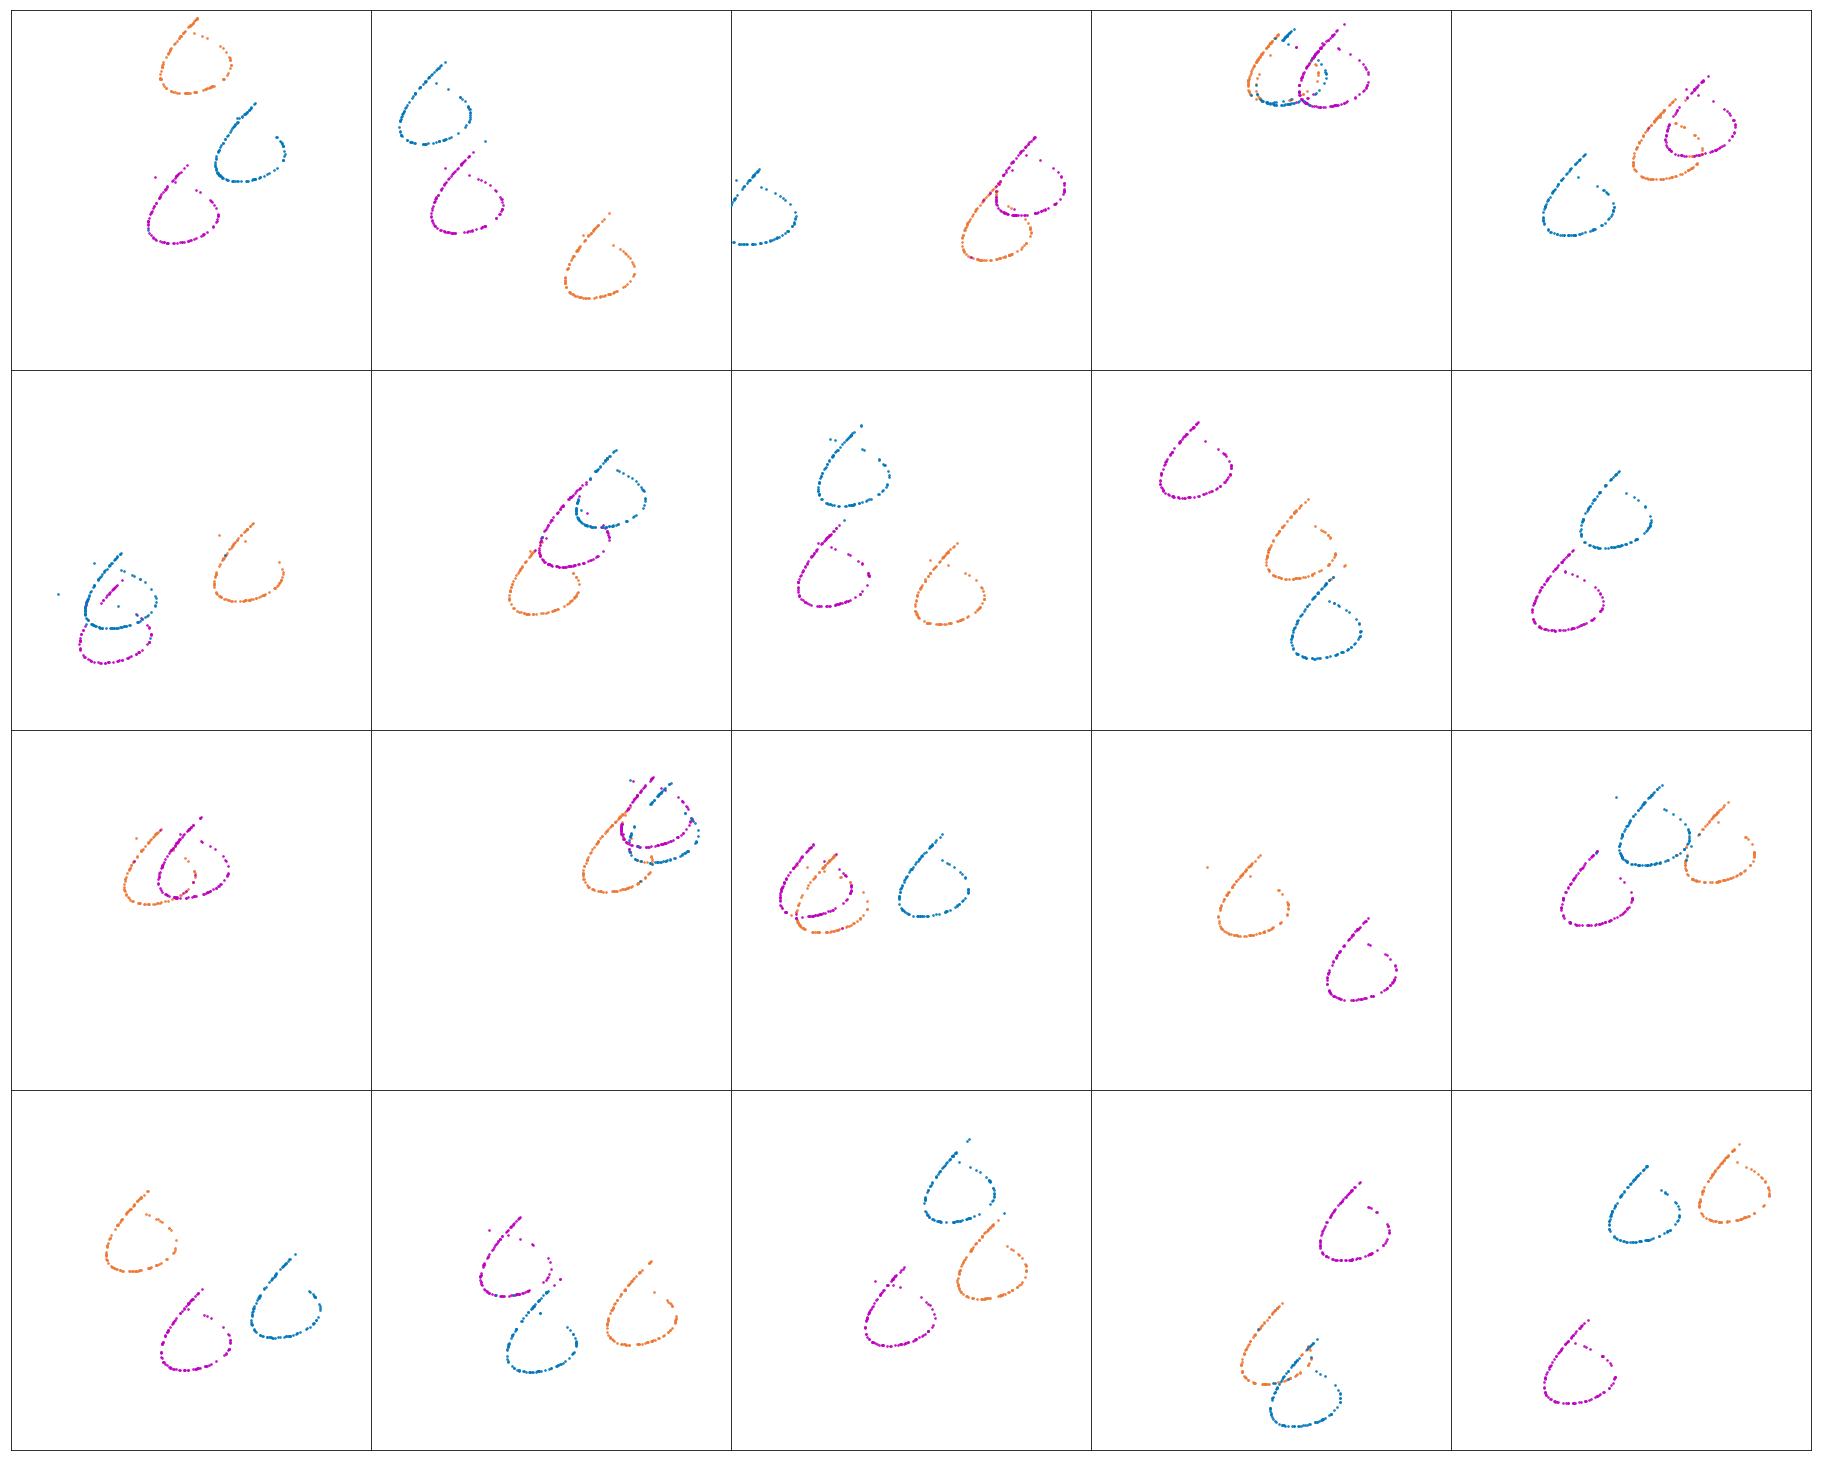

In [17]:
from forward_backward_pcg_v2 import *

indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
mu = MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
angle_true = ANGLE[batch_indices]
embed = shuffler(torch.cat((ob, angle_true), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        embed = embed.cuda()
        mu = mu.cuda()
ob = embed[:, :, :, :-1]
angle_true = embed[:, :, :, -1].unsqueeze(-1)
q_state, p_state = oneshot_state.forward(ob, mu, K)
state = q_state['zs'].value ## S * B * N * K
q_angle, p_angle = enc_angle(ob, state, mu)
angle = q_angle['angles'].value * 2 * math.pi
p_recon = dec_x(ob, state, angle, mu)
recon_mu = p_recon['likelihood'].dist.loc[0].cpu().data.numpy()
state_mu = q_state['zs'].dist.probs[0].cpu().data.numpy()
plot_recon(recon_mu, state_mu, PATH, 25, 10)

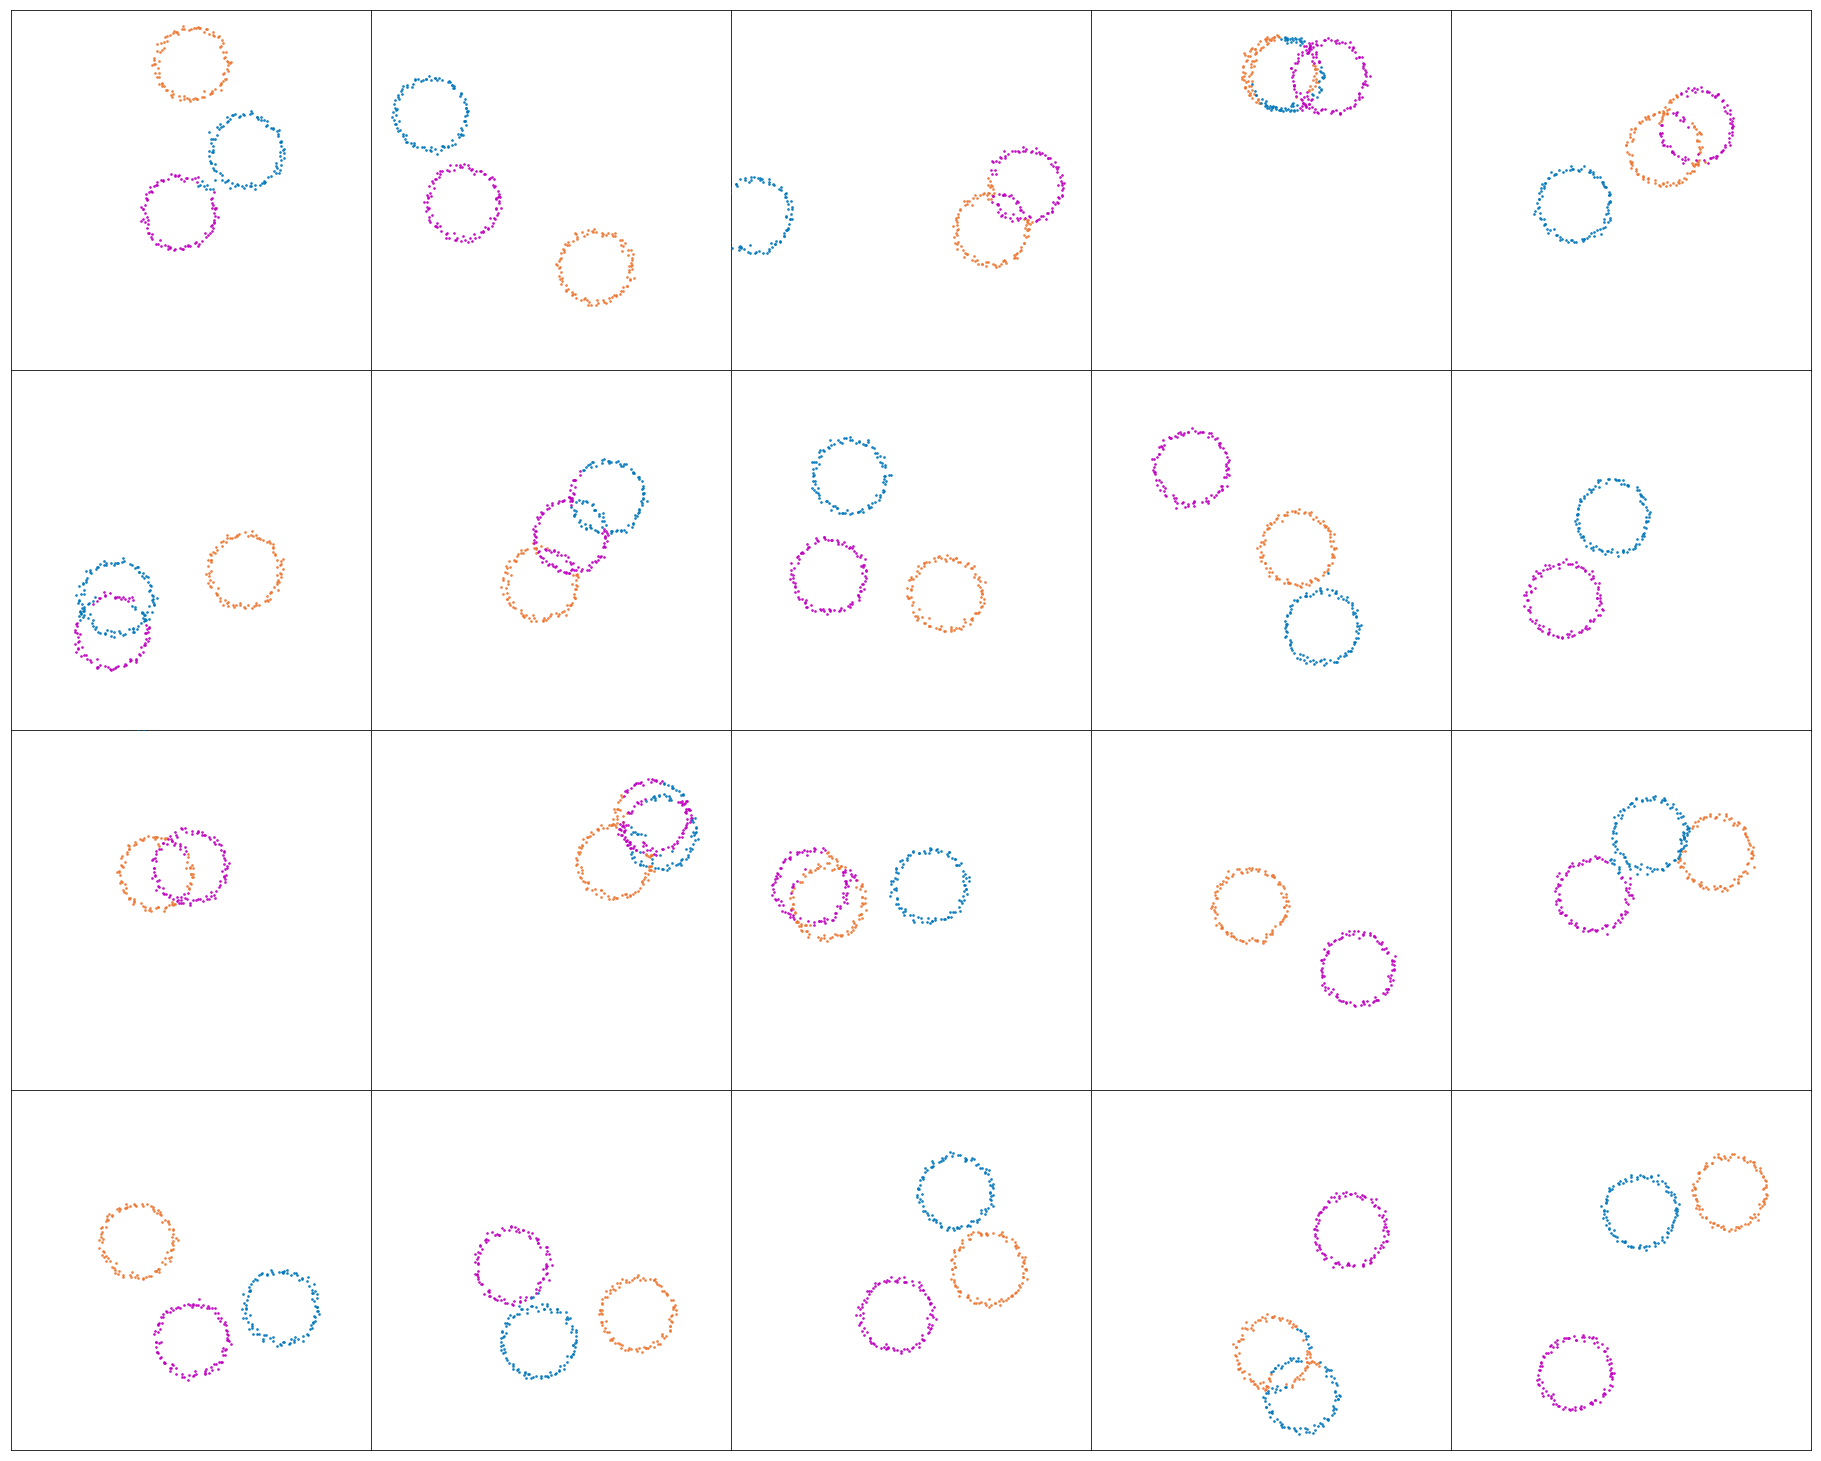

In [18]:
plot_recon(ob[0].cpu().data.numpy(), state_mu, PATH, 25, 10)

In [ ]:
plot_angles(angle, angle_true, 15)

In [ ]:
MAX_MCMC_STEPS = 10 ## 12 is maximum mcmc steps
data_ptr = 3
Vis_Interval = 2
page_width = 25
from forward_backward_dec import *

def plot_one_step(ob, state, mu, step, fig, gs, opacity, mu_marker, mu_marker_size, colors, title, data_flag=False):
    B, N, D = ob.shape
    for b in range(B):
        ax = fig.add_subplot(gs[b, step])
        xb = ob[b]
        if data_flag:
            ax.scatter(xb[:, 0], xb[:, 1], c='k', s=3.0, alpha=opacity, zorder=3)
        else:
            K = state.shape[-1]
            zb = state[b]
            mub = mu[b].reshape(K, D)
            assignments = zb.argmax(-1)
            for k in range(K):
                xk = xb[np.where(assignments == k)]
                ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], s=3.0, alpha=opacity, zorder=3)
                ax.scatter(mub[k, 0], mub[k, 1], marker=mu_marker, s= mu_marker_size, c=colors[k])
        ax.set_ylim([-12, 12])
        ax.set_xlim([-12, 12])
        ax.set_xticks([])
        ax.set_yticks([])
        if b == 0:
            ax.set_title(title, fontsize=20)
            
            
def plot_mc(models, Data, K, data_ptr, mcmc_steps, vis_interval, page_width, CUDA, device):
    sample_size = 1
    batch_size = 5
    marker = 'X'
    marker_size = 100
    opacity = 0.8
#     plt.rc('axes',edgecolor='#eeeeee')
    colors = ['#EE7733', 'm', '#0077BB', '#009988']
    gs = gridspec.GridSpec(batch_size, 2+int(mcmc_steps / vis_interval))
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(page_width,page_width*5/7))
    num_datasets = Data.shape[0]
    indices = torch.arange(num_datasets)
    batch_indices = indices[data_ptr*batch_size : (data_ptr+1)*batch_size]
    ob = Data[batch_indices]
    ob = shuffler(ob).repeat(sample_size, 1, 1, 1)
    if CUDA:
        with torch.cuda.device(device):
            ob =ob.cuda()
    test_ob = ob[0].cpu().data.numpy()
    (oneshot_mu, oneshot_state, enc_angle, enc_mu, enc_state, dec_x) = models
    plot_one_step(test_ob, [], [], 0, fig, gs, opacity, marker, marker_size, colors, 'Data', data_flag=True)
    state, angle, mu, w, eubo, elbo, q_mu, q_state = oneshot(oneshot_mu, oneshot_state, enc_angle, dec_x, ob, K)
    E_state = q_state['zs'].dist.probs[0].cpu().data.numpy()
    E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
    plot_one_step(test_ob, E_state, E_mu, 1, fig, gs, opacity, marker, marker_size, colors, 'One-shot')
    for m in range(mcmc_steps):
        if m == 0:
            state = resample(state, w, idw_flag=False) ## resample state
            angle = resample(angle, w, idw_flag=False)
        else:
            angle = resample(angle, w_angle, idw_flag=True)
        ## update mu
        mu, w_mu, eubo_mu, elbo_mu, q_mu, _  = Update_mu(enc_mu, dec_x, ob, state, angle, mu, K)
        mu = resample(mu, w_mu, idw_flag=True)
        ## update z
        state, w_state, eubo_state, elbo_state, q_state, _ = Update_state(enc_state, dec_x, ob, angle, mu, state)
        state = resample(state, w_state, idw_flag=True)
        ##update angle
        angle, w_angle, eubo_angle, elbo_angle, _, _ = Update_angle(enc_angle, dec_x, ob, state, mu, angle)
        if (m+1) % vis_interval == 0:
            E_state = q_state['zs'].dist.probs[0].cpu().data.numpy()
            E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
            plot_one_step(test_ob, E_state, E_mu, int((m+1) / vis_interval)+1, fig, gs, opacity, marker, marker_size, colors, 'Step %d' % (m+1))
    plt.savefig('samples.png')
            
plot_mc(models, OB, K, data_ptr, MAX_MCMC_STEPS, Vis_Interval, page_width, CUDA, DEVICE)